# Prepare MIDI Files for Training

In [2]:
import os
import torch
from tqdm import tqdm
from miditok import REMI, TokenizerConfig, TokSequence
from miditok.pytorch_data import split_files_for_training
from pathlib import Path

In [2]:
midi_dir = '/home/sampadk04/code/Tests/transformer/data/midi/test_data'

midi_raw_dir = os.path.join(midi_dir, 'raw/maestro-v2.0.0/')

save_dir = os.path.join(midi_dir, 'preprocessed_data')

In [3]:
# extract the midi file paths
midi_paths = list(Path(midi_raw_dir).glob('**/*.mid')) + list(Path(midi_raw_dir).glob('**/*.midi'))

print("# MIDI FILES:", len(midi_paths))

# MIDI FILES: 1282


## Training the Tokenizer

In [4]:
# train a tokenizer with BPE
vocab_size = 30000
max_seq_len = 1024
min_seq_len = 256
batch_size = 64

In [5]:
# Creating a multitrack tokenizer configuration, read the doc to explore other parameters

# Our parameters
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": False,
    "use_programs": False,
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
}
config = TokenizerConfig(**TOKENIZER_PARAMS)

# Creating the tokenizer
tokenizer = REMI(config)

# Add custom START token
tokenizer.add_to_vocab("START_None", special_token=True)

/tmp/ipykernel_197881/3605895432.py:17: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  config = TokenizerConfig(**TOKENIZER_PARAMS)


In [6]:
%%time
# train the tokenizer
tokenizer.train(
    vocab_size=vocab_size,
    model="BPE",
    files_paths=midi_paths,
)

tokenizer.save_params(os.path.join(save_dir, 'tokenizer', 'tokenizer.json'))




CPU times: user 10min 45s, sys: 1min 37s, total: 12min 23s
Wall time: 5min 11s


### Converting MIDI File to Token IDs

In [10]:
sample_midi_path = midi_paths[10]

sample_tokseq = tokenizer.encode(sample_midi_path)[0]

token_ids = sample_tokseq.ids

In [11]:
print("# of tokens:", len(token_ids))
print(token_ids[:10])

# of tokens: 3926
[2173, 2392, 4864, 49, 5149, 22, 333, 2912, 312, 2096]


In [12]:
tokenizer.decode_token_ids(sample_tokseq)
tokseq_decoded = tokenizer.decode([sample_tokseq])

In [13]:
tokseq_decoded

Score(ttype=Tick, tpq=8, begin=0, end=9161, tracks=1, notes=2279, time_sig=1, key_sig=0, markers=0, lyrics=0)

In [ ]:
# save the decoded file as midi file
# tokseq_decoded.dump_midi(os.path.join(save_dir, 'test.mid'))

### Converting Token IDs to MIDI File

In [15]:
# processing just using the token_ids
custom_tokseq = TokSequence(ids=token_ids)
tokenizer.decode_token_ids(custom_tokseq)
decoded_token_ids = custom_tokseq.ids
custom_tokseq_decoded = tokenizer.decode([decoded_token_ids])

In [16]:
custom_tokseq_decoded

Score(ttype=Tick, tpq=8, begin=0, end=9161, tracks=1, notes=2279, time_sig=1, key_sig=0, markers=0, lyrics=0)

# Splitting the Midi Files

In [7]:
midi_chunk_dir = Path('/storage/hdd1/data/midi_dataset/raw_data/maestro-v2-chunked')
_ = split_files_for_training(
    files_paths=midi_paths,
    tokenizer=tokenizer,
    save_dir=midi_chunk_dir,
    max_seq_len=max_seq_len,
    min_seq_len=min_seq_len
)

Splitting music files (/storage/hdd1/data/midi_dataset/raw_data/maestro-v2-chunked): 100%|██████████| 1282/1282 [00:19<00:00, 65.33it/s]


In [8]:
midi_chunk_paths = list(midi_chunk_dir.glob('**/*.mid')) + list(midi_chunk_dir.glob('**/*.midi'))

print("# MIDI CHUNK FILES:", len(midi_chunk_paths))

# MIDI CHUNK FILES: 10567


In [9]:
# comparing sizes of original midi files and chunked midi files

for i in range(10):
    midi_path_1 = midi_paths[i]
    midi_path_2 = midi_chunk_paths[i]

    tokseq_1 = tokenizer.encode(midi_path_1)[0]
    tokseq_2 = tokenizer.encode(midi_path_2)[0]

    token_ids_1 = tokseq_1.ids
    token_ids_2 = tokseq_2.ids

    print("Original MIDI file size:", len(token_ids_1))
    print("Chunked MIDI file size:", len(token_ids_2))

    print("Original TOKENS:", token_ids_1[:10])
    print("Chunked TOKENS:", token_ids_2[:10])

Original MIDI file size: 9884
Chunked MIDI file size: 924
Original TOKENS: [1924, 1979, 4130, 2704, 3641, 1420, 49, 1184, 37, 2139]
Chunked TOKENS: [1924, 24550, 7571, 201, 2420, 2925, 344, 29550, 28399, 22359]
Original MIDI file size: 6544
Chunked MIDI file size: 898
Original TOKENS: [1924, 2080, 329, 2252, 255, 1992, 20497, 1583, 210, 1375]
Chunked TOKENS: [1924, 1155, 10496, 399, 9450, 6894, 397, 11215, 10395, 4162]
Original MIDI file size: 7722
Chunked MIDI file size: 876
Original TOKENS: [1924, 1733, 4029, 1613, 209, 1079, 211, 1056, 1606, 5534]
Chunked TOKENS: [1924, 17718, 501, 192, 1601, 350, 7003, 10978, 434, 2686]
Original MIDI file size: 34155
Chunked MIDI file size: 994
Original TOKENS: [1924, 3051, 721, 71, 685, 35, 538, 14875, 23, 451]
Chunked TOKENS: [1924, 195, 1435, 386, 462, 363, 14153, 923, 574, 351]
Original MIDI file size: 5420
Chunked MIDI file size: 1050
Original TOKENS: [1924, 205, 1378, 1192, 985, 21309, 863, 1799, 5436, 1059]
Chunked TOKENS: [1924, 6949, 4242,

In [10]:
# pad token id
pad_token_id = tokenizer.pad_token_id
print(pad_token_id)

# start_token_id
start_token_id = tokenizer["START_None"]
print(start_token_id)

0
328


In [11]:
print(tokenizer.special_tokens)
print(tokenizer.special_tokens_ids)

['PAD_None', 'BOS_None', 'EOS_None', 'MASK_None', 'START_None']
[0, 1, 2, 3, 328]


## Experiment

In [26]:
# sample midi chunk for experimenting

sample_midi_chunk_path = midi_chunk_paths[10]

chunk_tokseq = tokenizer.encode(sample_midi_chunk_path)[0]

chunk_token_ids = chunk_tokseq.ids

print("# of tokens:", len(chunk_token_ids))
# print last 10 tokens
print(chunk_token_ids[-10:])

# of tokens: 1265
[396, 2216, 295, 4957, 7247, 1502, 305, 4283, 1718, 291]


In [27]:
# decode and save the midi chunk
tokenizer.decode_token_ids(chunk_tokseq)
chunk_tokseq_decoded = tokenizer.decode([chunk_tokseq])

# save the decoded file as midi file
chunk_tokseq_decoded.dump_midi(os.path.join(save_dir, 'test_chunk_org.mid'))

In [28]:
# manipulate the token_ids by padding at the end with pad_token_id

n_pad_tokens = 100
new_token_ids = chunk_token_ids + [pad_token_id] * n_pad_tokens

print("# of tokens:", len(new_token_ids))
# print last 10 tokens
print(new_token_ids[-10:])

# of tokens: 1365
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
# decode and save the midi chunk
new_pad_tokseq = TokSequence(ids=new_token_ids)
tokenizer.decode_token_ids(new_pad_tokseq)
new_pad_decoded_ids = new_pad_tokseq.ids
new_pad_tokseq_decoded = tokenizer.decode([new_pad_decoded_ids])

# save the decoded file as midi file
new_pad_tokseq_decoded.dump_midi(os.path.join(save_dir, 'test_chunk_pad.mid'))

## Load and use saved Tokenizer

In [5]:
tokenizer_dir = os.path.join(save_dir, 'tokenizer')

tokenizer_loaded = REMI.from_pretrained(tokenizer_dir)

config.json not found in /home/sampadk04/code/Tests/transformer/data/midi/test_data/preprocessed_data/tokenizer
/storage/hdd1/data/pyenvs/.mamba_venv/lib/python3.11/site-packages/miditok/midi_tokenizer.py:3252: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  self.config = TokenizerConfig()
/storage/hdd1/data/pyenvs/.mamba_venv/lib/python3.11/site-packages/miditok/classes.py:702: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  return cls(**input_dict, **kwargs)


In [7]:
# extract the midi file paths
midi_paths = list(Path(midi_raw_dir).glob('**/*.mid')) + list(Path(midi_raw_dir).glob('**/*.midi'))

print("# MIDI FILES:", len(midi_paths))

midi_chunk_dir = Path('/storage/hdd1/data/midi_dataset/raw_data/maestro-v2-chunked')
midi_chunk_paths = list(midi_chunk_dir.glob('**/*.mid')) + list(midi_chunk_dir.glob('**/*.midi'))

print("# MIDI CHUNK FILES:", len(midi_chunk_paths))

# MIDI FILES: 1282
# MIDI CHUNK FILES: 10567


In [8]:
# comparing sizes of original midi files and chunked midi files

for i in range(10):
    midi_path_1 = midi_paths[i]
    midi_path_2 = midi_chunk_paths[i]

    tokseq_1 = tokenizer_loaded.encode(midi_path_1)[0]
    tokseq_2 = tokenizer_loaded.encode(midi_path_2)[0]

    token_ids_1 = tokseq_1.ids
    token_ids_2 = tokseq_2.ids

    print("Original MIDI file size:", len(token_ids_1))
    print("Chunked MIDI file size:", len(token_ids_2))

    print("Original TOKENS:", token_ids_1[:10])
    print("Chunked TOKENS:", token_ids_2[:10])

Original MIDI file size: 9884
Chunked MIDI file size: 924
Original TOKENS: [1924, 1979, 4130, 2704, 3641, 1420, 49, 1184, 37, 2139]
Chunked TOKENS: [1924, 24550, 7571, 201, 2420, 2925, 344, 29550, 28399, 22359]
Original MIDI file size: 6544
Chunked MIDI file size: 898
Original TOKENS: [1924, 2080, 329, 2252, 255, 1992, 20497, 1583, 210, 1375]
Chunked TOKENS: [1924, 1155, 10496, 399, 9450, 6894, 397, 11215, 10395, 4162]
Original MIDI file size: 7722
Chunked MIDI file size: 876
Original TOKENS: [1924, 1733, 4029, 1613, 209, 1079, 211, 1056, 1606, 5534]
Chunked TOKENS: [1924, 17718, 501, 192, 1601, 350, 7003, 10978, 434, 2686]
Original MIDI file size: 34155
Chunked MIDI file size: 994
Original TOKENS: [1924, 3051, 721, 71, 685, 35, 538, 14875, 23, 451]
Chunked TOKENS: [1924, 195, 1435, 386, 462, 363, 14153, 923, 574, 351]
Original MIDI file size: 5420
Chunked MIDI file size: 1050
Original TOKENS: [1924, 205, 1378, 1192, 985, 21309, 863, 1799, 5436, 1059]
Chunked TOKENS: [1924, 6949, 4242,

In [9]:
print(tokenizer_loaded.special_tokens)
print(tokenizer_loaded.special_tokens_ids)

['PAD_None', 'BOS_None', 'EOS_None', 'MASK_None', 'START_None']
[0, 1, 2, 3, 328]


# TEST

In [3]:
import random
import numpy as np

ext_data_dir = '/storage/hdd1/data/midi_dataset/raw_data/maestro-v2-chunked'
block_size = 256

midi_tokenizer_dir = os.path.join(ext_data_dir, 'tokenizer_8k')

# load the tokenizer
tokenizer = REMI.from_pretrained(midi_tokenizer_dir)

# set the special token ids
pad_token_id = tokenizer['PAD_None']
start_token_id = tokenizer['BOS_None']

# extract midi file paths
midi_files = list(Path(ext_data_dir).rglob('*.midi')) + list(Path(ext_data_dir).rglob('*.mid'))
print(f"Found {len(midi_files)} MIDI files in {ext_data_dir}")

# set seed for train/val
train_val_split_seed = 1234

# initialize list to store the midi token_ids
midi_token_ids = []
for midi_file in tqdm(midi_files):
    try:
        midi_tokseq = tokenizer.encode(midi_file)[0]
        # extract the token ids and add the start_token_id to the beginning
        token_ids = [start_token_id] + midi_tokseq.ids

        # check if this is greater than the block_size, if not append pad_token_id to the end
        if len(token_ids) < block_size:
            token_ids += [pad_token_id for _ in range(block_size - len(token_ids))]

        midi_token_ids.append(token_ids)
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")

config.json not found in /storage/hdd1/data/midi_dataset/raw_data/maestro-v2-chunked/tokenizer_8k
/storage/hdd1/data/pyenvs/.mamba_venv/lib/python3.11/site-packages/miditok/midi_tokenizer.py:3252: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  self.config = TokenizerConfig()
/storage/hdd1/data/pyenvs/.mamba_venv/lib/python3.11/site-packages/miditok/classes.py:702: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  return cls(**input_dict, **kwargs)


Found 10567 MIDI files in /storage/hdd1/data/midi_dataset/raw_data/maestro-v2-chunked


100%|██████████| 10567/10567 [01:47<00:00, 98.00it/s] 


In [4]:
split_idx = int(0.9 * len(midi_token_ids))
train_data = midi_token_ids[:split_idx]
val_data = midi_token_ids[split_idx:]

print("Length of train data:", len(train_data))
print("Length of val data:", len(val_data))

Length of train data: 9510
Length of val data: 1057


In [8]:
for i in range(5):
    print(train_data[i][:10])

for i in range(5):
    print(val_data[i][:10])

[1, 874, 715, 7417, 200, 2385, 2931, 334, 203, 1133]
[1, 234, 1141, 191, 419, 382, 193, 385, 6732, 381]
[1, 244, 408, 482, 191, 1597, 335, 6797, 193, 452]
[1, 324, 1407, 371, 448, 349, 195, 529, 898, 553]
[1, 4194, 4222, 1375, 193, 1327, 194, 1166, 2289, 250]
[1, 4, 2253, 309, 47, 816, 32, 776, 2483, 816]
[1, 234, 631, 604, 59, 480, 190, 1156, 4890, 192]
[1, 234, 987, 3311, 4220, 2910, 2526, 913, 45, 480]
[1, 3413, 708, 3635, 617, 192, 2084, 820, 193, 2993]
[1, 5826, 587, 4007, 5361, 3802, 480, 38, 315, 1899]


In [9]:
import pickle

# preprocesses data
preprocessed_data_dir = os.path.join(ext_data_dir, 'preprocessed_data')
os.makedirs(preprocessed_data_dir, exist_ok=True)

# save the train and val data
train_data_path = os.path.join(preprocessed_data_dir, 'train.pkl')
val_data_path = os.path.join(preprocessed_data_dir, 'val.pkl')

with open(train_data_path, 'wb') as f:
    pickle.dump(train_data, f)

with open(val_data_path, 'wb') as f:
    pickle.dump(val_data, f)

In [10]:
# load the train and val data
with open(train_data_path, 'rb') as f:
    loaded_train_data = pickle.load(f)

with open(val_data_path, 'rb') as f:
    loaded_val_data = pickle.load(f)

print("Length of loaded train data:", len(loaded_train_data))
print("Length of loaded val data:", len(loaded_val_data))

Length of loaded train data: 9510
Length of loaded val data: 1057


In [12]:
for i in range(5):
    print(loaded_train_data[i][:10])

for i in range(5):
    print(loaded_val_data[i][:10])

[1, 874, 715, 7417, 200, 2385, 2931, 334, 203, 1133]
[1, 234, 1141, 191, 419, 382, 193, 385, 6732, 381]
[1, 244, 408, 482, 191, 1597, 335, 6797, 193, 452]
[1, 324, 1407, 371, 448, 349, 195, 529, 898, 553]
[1, 4194, 4222, 1375, 193, 1327, 194, 1166, 2289, 250]
[1, 4, 2253, 309, 47, 816, 32, 776, 2483, 816]
[1, 234, 631, 604, 59, 480, 190, 1156, 4890, 192]
[1, 234, 987, 3311, 4220, 2910, 2526, 913, 45, 480]
[1, 3413, 708, 3635, 617, 192, 2084, 820, 193, 2993]
[1, 5826, 587, 4007, 5361, 3802, 480, 38, 315, 1899]


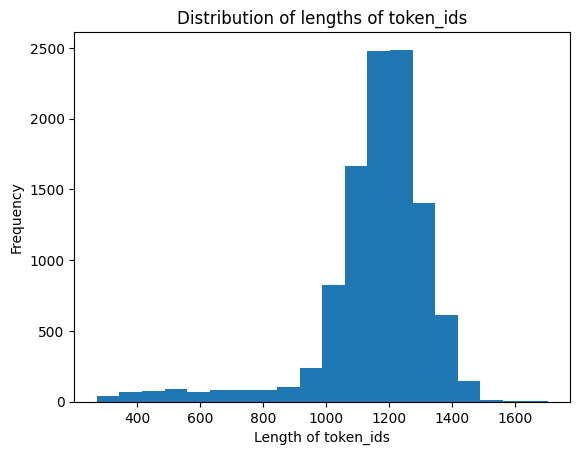

In [6]:
# plot distribution of lengths of the token_ids
data_lengths = [len(data) for data in midi_token_ids]

# plot the distribution of lengths
import matplotlib.pyplot as plt
plt.hist(data_lengths, bins=20)
plt.xlabel("Length of token_ids")
plt.ylabel("Frequency")
plt.title("Distribution of lengths of token_ids")
plt.show()

In [7]:
# get the summary statistics of the lengths
data_lengths = np.array(data_lengths)
print("Summary statistics of lengths of token_ids")
print("Min:", np.min(data_lengths))
print("Max:", np.max(data_lengths))
print("Mean:", np.mean(data_lengths))
print("Median:", np.median(data_lengths))
print("Std:", np.std(data_lengths))

Summary statistics of lengths of token_ids
Min: 272
Max: 1703
Mean: 1157.0417336992523
Median: 1186.0
Std: 179.7592763267505
